# Étude des Forces sur une Digue:

## Introduction:

Dans ce projet on cherche à trouver les conditions de stabilité de différentes formes de digues. On commencera par simplifier le problème avec certaines hypothèses. En suite on fera un bilan des forces qui sont appliquées à la digue afin de trouver les différentes conditions de stabilité. Tout cela fait, on comparera les cas entre eux avec un modèle prenant en compte toutes les grandeurs pertinentes.

## Hypothèses:

Dans ce projet, on considerera un objet immobile (équilibre statique translationel) à deux dimensions avec une somme de moments nulle, afin de négliger le mouvement rotationel, ainsi que les intégrales à trois dimension, car les forces sont invariantes selon la longeur de la digue. Les forces du poids et de la pression de l'eau sont toutes les deux très grandes devant celles de la pression de l'air, alors on négligera ces dernières. Dans tous les cas traités on supposera une hauteur de $H = 10m$ pour l'eau ainsi que la digue.

## Bilan des Forces:

Les forces appliquées à la digue dans le cadres des hypothèse précédentes sont les suivantes:

\begin{equation*}
    \vec{F_{g}} = - \rho_{digue} g \int f(y) dS \vec{u_y}
\end{equation*}

\begin{equation*}
    \vec{F_{p}}(y) = \rho_{eau} g (H - y) \vec{u_n}
\end{equation*}

\begin{equation*}
    \vec{F_{r}} = -\vec{F_{g}} \cdot \vec{u_y} - \vec{F_{p}} \cdot \vec{u_y}
\end{equation*}

\begin{equation*}
    \vec{F_{f}} = \mu |\vec{F_r}| \vec{u_x}, \mu \leq 0.5
\end{equation*}

Avec $\vec{F_g}$ la force de gravité, $\rho_{digue}$ sa masse volumique, $g$ la constante d'accélération gravitionelle, $f(y)$ la fontion qui décrit la forme de la digue à une hauteur $y$, $dS$ la surface infinitesimale, $\vec{F_p}$ la force de pression de l'eau sur la digue, $\rho_{eau}$ la masse volumique de l'eau, $\vec{F_r}$ la force de réaction normale au sol, $\vec{F_f}$ la force de frottement entre la digue et le sol, $\mu$ le coefficient de frottement statique entre la digue et sol, $\vec{u_x}$ et $\vec{u_y}$ les vecteurs unitaires du plan cartésien, et $\vec{u_n}$ le vecteur normal à la surface de la digue. 

Pour les fonctions de la digue on observe une force pression qui varie en direction, alors pour trouver ses composantes cartésiennes:

$$
\vec{F_p} = \iint_S \vec{\mathrm{d}F_p} =\int_0^H F_p(y) \mathrm{d}l  \vec{u_n}
$$


$$
\mathrm{d}l = \frac{\mathrm{d}y}{\cos(\theta)}
$$


$$
tan(\theta) = f'(y)
$$

Le vecteur $\vec{u_n}$ est alors donné par :

$$
\vec{u_n} = \sin(\theta) \cdot \vec{u_y} - \cos(\theta) . \vec{u_x} 
$$

## Création d'un Modèle:

On commence par créer des fonctions générales pour dériver et intégrer dans la suite. On appuie sur les équations d'avant pour écrire des fonctions qui permettent de calculer chaque force appliquée sur la digue selon $\vec{u_x}$ et $\vec{u_y}$. Enfin on définit une fonction qui permet de calculer le rapport entre les forces verticales et les forces horizontales appliquées à la digue, et donc qui renvoie le coefficient de frottement requis pour stabilité dans chaque cas.

In [1]:
# Importer les modules requis
# pour le projet
import numpy as np
import numpy.linalg as lg
import matplotlib.pyplot as plt
from numba import jit

# Définition et style des figures
imsize = 200
plt.style.use("dark_background")

# Constantes
H, xa, xe, g = 10, -5, 5, 9.81
y = np.linspace(0, H, 1000)



# Création des fonctions générales
# pour dériver et integrer
#@jit
def integral(f, b, feau, xe = 0,  abs = "absolute", a=0):
    n = np.array(10**3)
    x = np.array(np.linspace(a, b, n))
    dx = (np.array(b, dtype=np.float64)-np.array(a, dtype=np.float64))/n
    sum = np.array(0, dtype=np.float64)
    area = np.zeros(n)
    for i in range(n):
        #if i % 60 == 0:
        #    print(f"Integrating {f:}: {np.round(i/n * 100):}%")
        if np.logical_or(f == pressurediffrential_x, f == pressurediffrential_y):
            area[i] = (f(x, xe, feau))[i] * dx
        else:
            area[i] = (f(x, xe))[i] * dx
    if abs == "absolute":
        integral = np.sum(np.abs(area))
    else:
        integral = np.sum(area)
    return np.round(integral, 6)

#@jit
def derivitive(x, y):
    derivitive = np.zeros(len(x)-1)
    for i in range(len(x)-1):
        #if i % 75 == 0:
        #    print(f"Calculating derivitive :{np.round(i/(len(x)-1)*100):}%")
        derivitive[i] = (y[i+1] - y[i])/(x[i+1] - x[i])
    return derivitive

#@jit
def Fg(fair, feau, xa, xe):
    if xa == 0:
        mass = 3000 * (integral(feau, H, feau, xe=xe, abs = "absolute"))
    elif xe == 0:
        mass = 3000 * (integral(fair, H, feau, xe=xa, abs = "absolute"))
    elif fair == feau:
        mass = 3000 * 2 * integral(feau, H, feau, xe=xe, abs = "absolute")
    else:
        mass = 3000 * (integral(fair, H, fair, xe=xa, abs = "absolute") + integral(feau, H, feau, xe= xe, abs = "absolute"))
    Fg = np.zeros(2)
    Fg[1] = - mass * g
    return Fg

#@jit
def pressure(x, rho=1000, g=9.81):
    return rho * g * (H - x)

#@jit
def pressurediffrential_x(y, xe, feau ):
    pressuredifferential_inx = np.zeros_like(y)
    yprime = derivitive(y, feau(y, xe))
    for i in range(len(yprime)):
        #if i % 75 == 0:
        #    print(f"Calculating pressure differential in x of {feau:}: {np.round(i/len(yprime)*100):}%")
        pressuredifferential_inx[i] = - pressure(y[i]) * (np.cos(np.arctan(yprime[i]))) ** (-1) * np.cos(np.arctan(yprime[i]))
    return pressuredifferential_inx

#@jit
def pressurediffrential_y(y, xe, feau ):
    pressuredifferential_iny = np.zeros_like(y)
    yprime = derivitive(y, feau(y, xe))
    for i in range(len(yprime)):
        #if i % 75 == 0:
        #    print(f"Calculating pressure differential in y of {feau:}: {np.round(i/len(yprime)*100):}%")
        pressuredifferential_iny[i] = pressure(y[i]) * (np.cos(np.arctan(yprime[i]) ) )**(-1) * np.sin(np.arctan(yprime[i]) )
    return pressuredifferential_iny

#@jit
def Fp(feau, xe, y = y):
    forcepressure_x = integral(pressurediffrential_x, H, feau, xe,  abs=0)
    forcepressure_y = integral(pressurediffrential_y, H, feau, xe,  abs=0)
    Fpressure = np.array(((forcepressure_x), (forcepressure_y)))
    return Fpressure

#@jit
def ToverN(fair, feau, xa, xe, y):
    stability = (Fp(feau, xe, y)[0]) / (Fg(fair, feau, xa, xe)[1] + Fp(feau, xe, y)[1])
    print(f"Coefficient de frottement statique minimal pour stabilité pour la fonction {feau:} à xe = {xe:}: {np.round(stability, 5):}")
    return stability

## Application aux formes différentes:

On définit les fonctions qui décrivent les formes de chaques cas, que l'on analysera, avec $x_e$ la largeur au côté "eau", et $x_a$ la largeur au côté "air".

In [2]:
# Fonctions de la pression à une hauteur
# donnée, les formes affine et concave de
# la digue et sa masse
#@jit
def fairlinear(y, xa = -5):
    return -(y - H) * xa / H

#@jit
def feaulinear(y, xe = 5):
    return  -(y - H) * xe / H

#@jit
def feauconcave(y, xe = 5, a = 3):
    return a*(y/H)**2 - (a + xe)*(y/H) +xe

### 1. Cas de Digue Affine

Dans la figure ci-dessous, on trace une digue avec les deux pentes constantes. On observe que le coefficient de frottement statique requis pour stabilité $\mu = 0.29 \leq 0.5$, alors la digue reste immobile. Dans ce cas: $x_a = -5$, $x_e = 5$. La forme est donnée par:

\begin{equation*}
    f_{air|eau}(y) = -\frac{x_{a|e}}{H} \cdot (y-H)
\end{equation*}

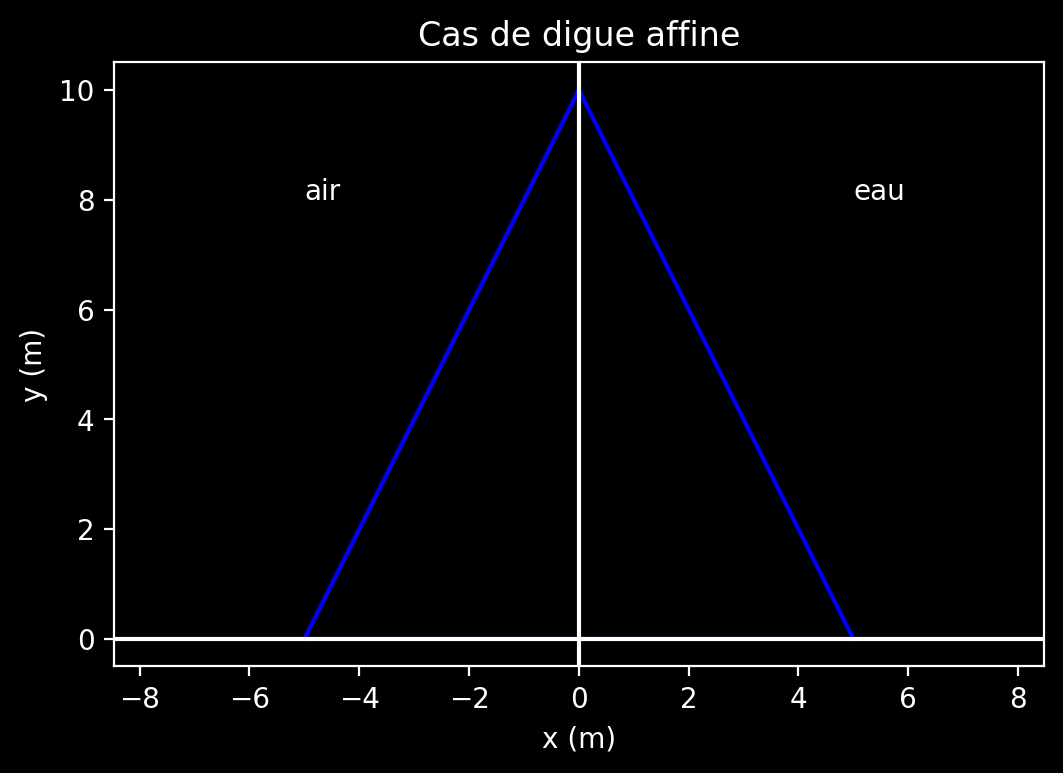

Coefficient de frottement statique minimal pour stabilité pour la fonction <function feaulinear at 0x000002F9350E8700> à xe = 5: 0.28571


0.2857142857142857

In [3]:
plt.figure(dpi=imsize)
plt.plot(fairlinear(y), y, '-b')
plt.plot(feaulinear(y), y, '-b')
plt.plot([xe, xa], [0, 0], '-b')  # Bas de la digue
plt.title("Cas de digue affine")
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.text(xe, 8, 'eau')
plt.text(xa, 8, 'air')
plt.axis('equal')  # Permet d'avoir un plot isométrique
plt.axhline(0, color="white")
plt.axvline(0, color="white")
plt.xlim(-8, 8)
plt.show()

ToverN(fairlinear, feaulinear, -5, 5, y)

### 2. Cas de Digue Concave

Dans la figure ci-dessous, on trace une digue avec les deux pentes courbées. On observe que le coefficient de frottement statique requis pour stabilité $\mu = 0.33 \leq 0.5$, alors la digue reste immobile. Dans ce cas: $x_a = -5$, $x_e = 5$. La forme est donnée par:

\begin{equation*}
    f_{air|eau}(y) = a \left(\frac{y}{H}\right)^2-(a+x_e)\left(\frac{y}{H}\right) +x_e
\end{equation*}

Dans la suite on prendra la constante $a=3$.

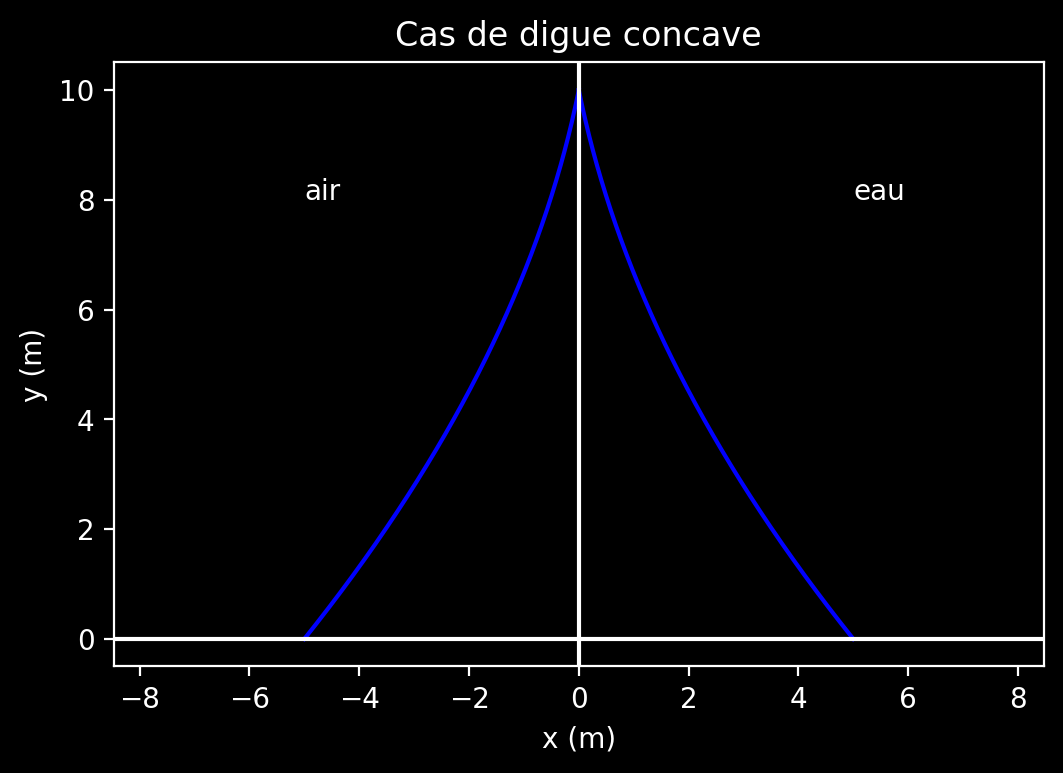

Coefficient de frottement statique minimal pour stabilité pour la fonction <function feauconcave at 0x000002F938328700> à xe = 5: 0.33328


0.33327773150955775

In [4]:
plt.figure(dpi = imsize)
plt.plot(feauconcave(y), y, "-b")
plt.plot(-feauconcave(y), y, "-b")
plt.axhline(0, color="white")
plt.axvline(0, color="white")
plt.axis('equal')
plt.title("Cas de digue concave")
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.text(xe, 8, 'eau')
plt.text(xa, 8, 'air')
plt.show()

ToverN(feauconcave, feauconcave, -5, 5, y)

### 3. Cas de Demi Digue Concave

Dans la figure ci-dessous, on trace une digue avec une pente courbée et une ligne verticale de $y=0$ à $y=10$ placée à $x=0$. On observe que le coefficient de frottement statique requis pour stabilité $\mu = 0.56 \geq 0.5$, alors la digue n'est plus en equilibre translationel. Dans ce cas: $x_a = 0$, $x_e =$ {$5, 6$}. On constate que, en prenant $x_e = 6$, la digue est en equilibre translationel ($\mu = 0.45$) malgré un volume, est donc un poids, bien inférieur à ceux des digues "doubles". En comparant les demi-digues affine et concave, il est évident que le coefficient de la fonction affine $\mu = 0.5$ mène à une situation où la digue est sur le point d'accélération, tandis que celui de la fonction concave est stable ($\mu = 0.45$). La forme est donnée par:

\begin{equation*}
    f_{eau}(y) = a \left(\frac{y}{H}\right)^2-(a+x_e)\left(\frac{y}{H}\right) +x_e
\end{equation*}

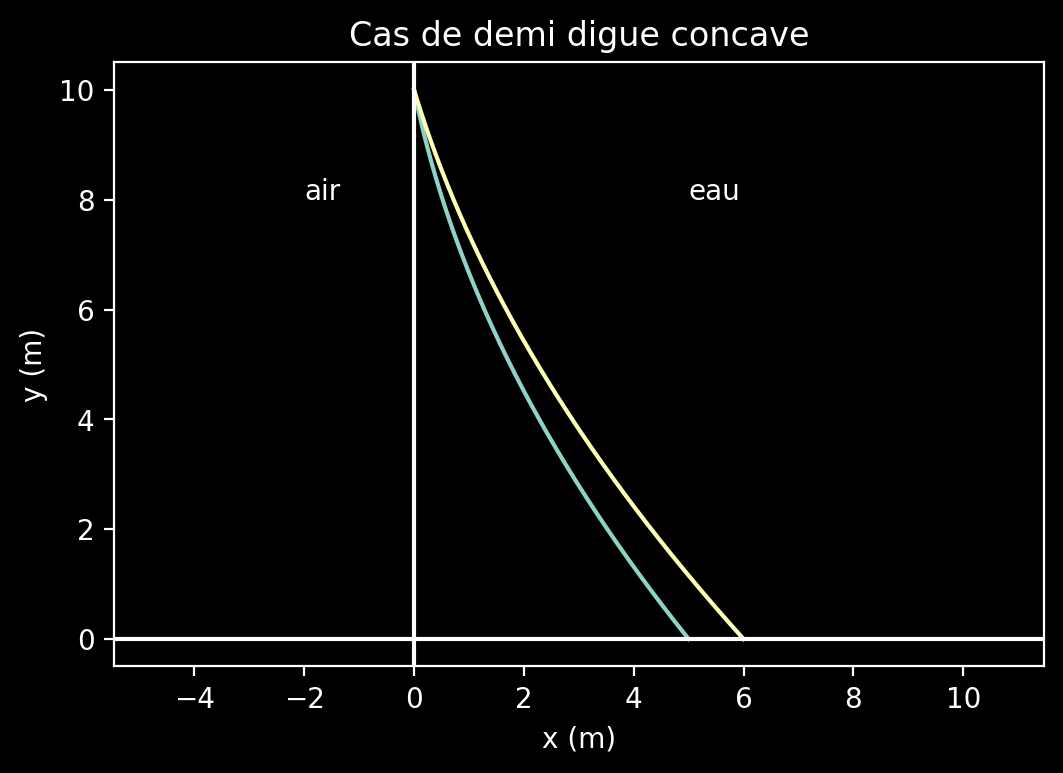

Coefficient de frottement statique minimal pour stabilité pour la fonction <function feauconcave at 0x000002F938328700> à xe = 5: 0.55549
Coefficient de frottement statique minimal pour stabilité pour la fonction <function feauconcave at 0x000002F938328700> à xe = 6: 0.4545
Coefficient de frottement statique minimal pour stabilité pour la fonction <function feaulinear at 0x000002F9350E8700> à xe = 5: 0.5


0.5

In [5]:
plt.figure(dpi = imsize)
plt.plot(feauconcave(y), y, "-")
plt.plot(feauconcave(y, xe = 6), y, "-")
plt.axhline(0, color="white")
plt.axvline(0, color="white")
plt.axis('equal')
plt.title("Cas de demi digue concave")
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.text(xe, 8, 'eau')
plt.text(xa +3 , 8, 'air')
plt.show()

ToverN(fairlinear, feauconcave, 0, 5, y)
ToverN(fairlinear, feauconcave, 0, 6, y)
ToverN(fairlinear, feaulinear, 0, 5, y)

## Impacte du Volume sur la Stabilité dans le Cas Demi-Digue Concave et Conclusion

En appliquant ce que l'on a observé lors de l'analyse des fonctions précédentes, on cherche maintenant à calculer le coefficient $\mu$ requis pour stabilité en fonction de différents $x_e \in [5,6]$, et de les tracer en fonction du volume pour ce même $x_e$. Cette figure permettra de trouver le volume minimal pour un état d'équilibre translationel. On voit que ce volume $V = 22.5m^3$ correspond à $\mu = 0.5$. Une forme courbe à l'intérface eau-béton réduis le volume mais fait croître la surface sur laquelle la pression est appliquée. Cette surface plus grande n'intervient pas dans le calculs de la force de pression selon $\vec{u_x}$, mais elle diminue bien la force due à la pression selon $\vec{u_y}$, ce qui fait baisser le coefficient de frottement nécessaire pour l'équilibre.

In [ ]:
def volume_stability(fair, feau, xa, xe, y):
    volume = np.zeros_like(xe)
    stability = np.zeros_like(xe)
    for i in range(len(volume)):
        volume[i] = integral(feau, H, feau, xe=xe[i], abs="absolute")
    for i in range(len(stability)):
        stability[i] = ToverN(fair, feau, xa, xe[i], y)
    return volume, stability

xegraph = np.linspace(5, 6, 15)
xgraph, ygraph = volume_stability(fairlinear, feauconcave, 0, xegraph, y)

plt.figure(dpi=imsize)
plt.plot(xgraph, ygraph)
plt.title("Coefficient nécessaire en fonction du volume")
plt.ylabel(r"Coefficient nécessaire pour équilibre ($\mu$ S.I.)")
plt.xlabel(r"Volume de la demi-digue ($V$/$m^3$)")
plt.axhline(0.5, color="white", linestyle = ":")
plt.axvline(22.5, color="white", linestyle = ":")
plt.yticks(rotation = 55)
plt.grid()
plt.show()